# Fingerprint Testing

The purpose of this notebook is to test and calculate the ROC of the **train set**, just to figure out the best way to do so. It will follow a notebook with a proper test set.

In [58]:
import re

import numpy as np
import pandas as pd

In [59]:
string_df = pd.read_csv("../../data/interim/string_df.csv")

In [60]:
string_df

,label,concatenated
0,GooglePixel3A_L,0000000000000100000000100000010000001011000101...
1,GooglePixel3A_L,0000000000000100000000100000010000001011000101...
2,GooglePixel3A_L,0000000000000100000000100000010000001011000101...
3,GooglePixel3A_L,0000000000000100000000100000010000001011000101...
4,GooglePixel3A_L,0000000000000100000000100000010000001011000101...
...,...,...
951,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...
952,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...
953,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...
954,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...


In [61]:
balanced_pairs_df = pd.read_csv("../../data/interim/balanced_pairs_df.csv", index_col=0)
balanced_pairs_df.reset_index(drop=True, inplace=True)

In [62]:
balanced_pairs_df

,Item 1,Item 2,Equality,device1,device2
0,767,858,1,XiaomiRedmi5_J,XiaomiRedmi5_J
1,767,858,1,XiaomiRedmi5_J,XiaomiRedmi5_J
2,672,789,1,XiaomiRedmi5_J,XiaomiRedmi5_J
3,672,789,1,XiaomiRedmi5_J,XiaomiRedmi5_J
4,748,761,1,XiaomiRedmi5_J,XiaomiRedmi5_J
...,...,...,...,...,...
4995,326,330,-1,iPhone11_M,iPhoneXSMax_M
4996,33,442,-1,iPhone12_W,iPhone11_M
4997,120,832,-1,iPhone11_M,XiaomiRedmiNote7_S
4998,274,774,-1,iPhone11_M,XiaomiRedmi5_J


In [63]:
best_filters = [
    "0[0] 🀫🀫🀫🀫🀫🀫🀫🀫 0[2280]",  # len ssid
    # "0[8] 🀫🀫🀫🀫🀫🀫🀫🀫 0[2272]", # len sup rates
    # "0[95] 🀫🀫🀫🀫🀫🀫🀫🀫 0[2185]", # len vst
    "0[2048] 🀫🀫🀫🀫🀫🀫🀫🀫 0[232]",
    # "0[1128] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1152]",
    "0[112] 🀫🀫🀫🀫🀆🀆🀆🀆 0[2168]",
    "0[1016] 🀆🀆🀆🀆🀫🀫🀫🀫 0[1264]",
    "0[1472] 🀆🀆🀆🀆🀫🀫🀫🀫 0[808]",
    "0[1696] 🀫🀫🀫🀫🀫🀫🀫🀫 0[584]",
    "0[1928] 🀫🀫🀫🀫🀫🀫🀫🀫 0[352]",
    # "0[2048] 🀫🀫🀫🀫🀆🀆🀆🀆 0[232]",
    "0[912] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1368]",
    # "0[2168] 🀫🀫🀫🀫🀆🀆🀆🀆 0[112]",
    "0[1480] 🀫🀫🀫🀫🀫🀫🀫🀫 0[800]",
    # "0[1144] 🀫🀫🀫🀫🀆🀆🀆🀆 0[1136]",
    "0[1368] 🀫🀫🀫🀫🀫🀫🀫🀫 0[912]",
    # "0[2056] 🀆🀆🀆🀆🀫🀫🀫🀫 0[224]",
    # "0[1944] 🀆🀆🀆🀆🀫🀫🀫🀫 0[336]",
    "0[2168] 🀫🀫🀫🀫🀫🀫🀫🀫 0[112]",
    # "0[1832] 🀆🀆🀆🀆🀫🀫🀫🀫 0[448]",
    # "0[1832] 🀫🀫🀫🀫🀆🀆🀆🀆 0[448]",
    "0[2056] 🀫🀫🀫🀫🀫🀫🀫🀫 0[224]",
    # "0[2176] 🀆🀆🀆🀆🀫🀫🀫🀫 0[104]",
    # "0[2176] 🀫🀫🀫🀫🀆🀆🀆🀆 0[104]",
]

In [64]:
best_thresholds = 8 * np.ones(
    len(best_filters)
)  # 8 is the threshold shared among the selected filters

## Functions

In [65]:
def convert_string_to_array(numeric_string: str) -> np.ndarray:
    # Extract numbers from the square brackets
    numbers = list(map(int, re.findall(r"\[([0-9]+)\]", numeric_string)))

    # Extract symbols between the square brackets, strip leading/trailing whitespace
    symbols = re.search(r"\](.*?)\[", numeric_string).group(1).strip()

    # Replace symbols
    symbol_map = {"🀆": -1, "🀫": 1}
    converted_symbols = [symbol_map[char] for char in symbols if char in symbol_map]

    # Construct the final array
    prefix_zeros = [0] * numbers[0]
    suffix_zeros = [0] * numbers[1]
    final_array = np.array(prefix_zeros + converted_symbols + suffix_zeros)

    return final_array

In [66]:
def generate_fingerprint(
    probe_burst: str, selected_filters: list, selected_thresholds: list
) -> list:
    probe_burst = np.array(list(probe_burst)).astype(int)

    selected_filter_arrays = []

    for selected_filter in selected_filters:
        selected_filter_array = convert_string_to_array(selected_filter)
        selected_filter_arrays.append(selected_filter_array)

    sum_array = []
    for selected_filter_array in selected_filter_arrays:
        sum_array.append(np.sum(np.multiply(probe_burst, selected_filter_array)))

    return sum_array

# Test filter only

Just to understand if the filters can discriminate between different probe burst, i will just filter each probe of the train set (without considering pairs and without using the thresholds). I will then proceed by grouping by filtered array.

In [67]:
string_df.iloc[0, 1]

'000000000000010000000010000001000000101100010110000000000000000000000000000000000000100000001100000100100001100000100100001100000100100001100000011011000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111000000000101000011110010000010000000000000100111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [68]:
fingerprints = []
for string in string_df["concatenated"]:
    fingerprint = generate_fingerprint(string, best_filters, best_thresholds)
    fingerprints.append(fingerprint)

In [69]:
string_df["fingerprint"] = fingerprints

In [70]:
string_df

,label,concatenated,fingerprint
0,GooglePixel3A_L,0000000000000100000000100000010000001011000101...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,GooglePixel3A_L,0000000000000100000000100000010000001011000101...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,GooglePixel3A_L,0000000000000100000000100000010000001011000101...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,GooglePixel3A_L,0000000000000100000000100000010000001011000101...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
4,GooglePixel3A_L,0000000000000100000000100000010000001011000101...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...
951,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
952,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
953,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
954,iPhoneXSMax_M,0000000000000100000000100000010000001011000101...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [71]:
string_df["fingerprint"] = string_df["fingerprint"].apply(
    lambda x: "".join(map(str, x))
)

In [72]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

In [73]:
string_df["fingerprint_label"] = label_encoder.fit_transform(string_df["fingerprint"])

In [74]:
string_df["fingerprint_label"].nunique()

13

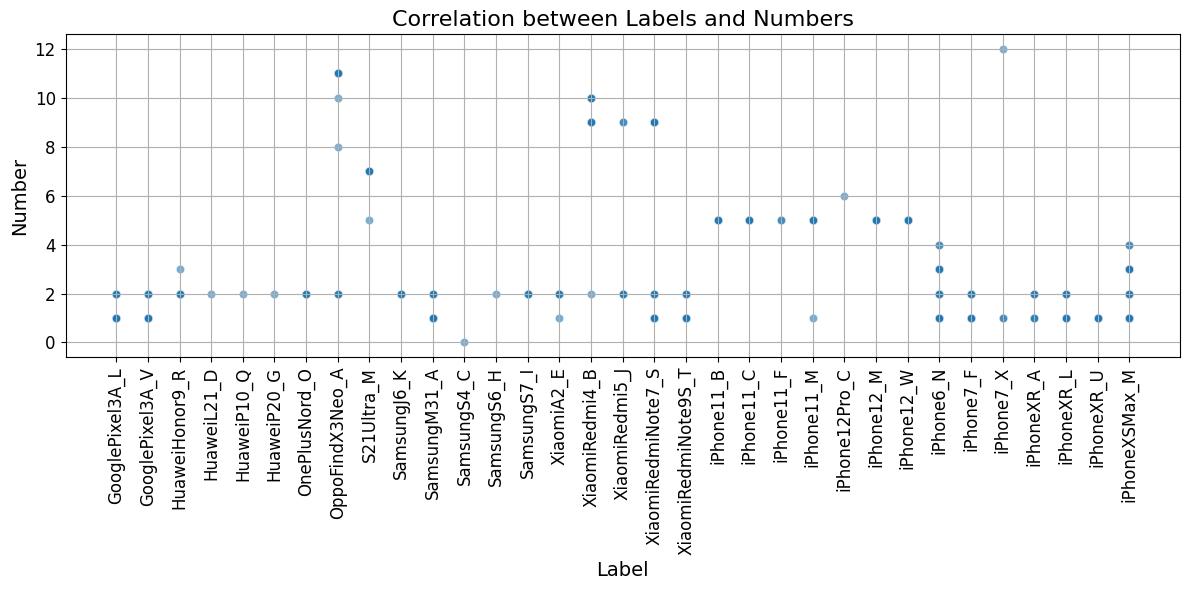

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the correlation between labels and numbers
plt.figure(figsize=(12, 6))
sns.scatterplot(x="label", y="fingerprint_label", data=string_df, alpha=0.6)
plt.title("Correlation between Labels and Numbers", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Number", fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
string_df[string_df["label"] == "iPhone6_N"]

,label,concatenated,fingerprint,fingerprint_label
758,iPhone6_N,0000000000000100000000100000010000001011000101...,000000000000,1
759,iPhone6_N,0000000000000100000000100000010000001011000101...,000000000000,1
760,iPhone6_N,0000000000000100000000100000010000001011000101...,000000000000,1
761,iPhone6_N,0000000000000100000000100000010000001011000101...,000000000010,2
762,iPhone6_N,0000000000000100000000100000010000001011000101...,000000000020,3
763,iPhone6_N,0000000000000100000000100000010000001011000101...,000000000000,1
764,iPhone6_N,0000000000000100000000100000010000001011000101...,000000000020,3
765,iPhone6_N,0000000000000100000000100000010000001011000101...,000000000020,3
766,iPhone6_N,0000000000000100000000100000010000001011000101...,000000000020,3
767,iPhone6_N,0000000000000100000000100000010000001011000101...,000000000020,3
